In [1]:
import aiohttp
import asyncio
import async_timeout

from bs4 import BeautifulSoup
import re

import numpy as np
import csv

import pymorphy2
import collections 
import multiprocessing

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

**Scrapping**

In [2]:
DATA = 'data.csv'

async def fetch(session, url):
    async with async_timeout.timeout(10):
        async with session.get(url) as response:
            return await response.text()
        
async def soup_d(html, display_result=False):
    soup = BeautifulSoup(html, 'html.parser')
    if display_result:
        print(soup.prettify())
    return soup
           
async def main():
    async with aiohttp.ClientSession() as session:
        url1 = 'http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/'
        url2 = '22914' # Текст каждой жалобы парсим отдельно
        data = []
        
        while len(data) < 1500: # 5 обращений на каждой странице * 300 страниц
            url = url1 + url2
            html = await fetch(session, url)
            soup = await soup_d(html)
            content_area = soup.find("p", {"class": 'appeal-details-message'})
            if content_area is None:
                url2 = str(int(url2)-1)
            else:
                text = re.sub(r'[\r]+', '', content_area.text)
                text = re.sub(r'[\n]+', ' ', text)
                data.append(text)
                url2 = str(int(url2)-1)
        
        data = np.array_split(data, 1500)
        with open(DATA, "w") as file:
            writer = csv.writer(file)
            writer.writerows(data)
            
        print('Over')
        
        
loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(main())
except:
    pass

Over


**Нормализация**

In [3]:
# Распaкуем данные

d = []
with open('data.csv') as File:  
    reader = csv.reader(File)
    for row in reader:
        d.append(row)
data = []
for l in d:
    data.extend(l) 

In [4]:
# Удалим пунктуацию
data = map(lambda x: re.sub('[,\.!?_]', '', x), data)
data = list(data)

# Удалим цифры
data = map(lambda x: re.sub(r'\d', '', x), data)
data = list(data)

In [5]:
#Функция нормализации

morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = text.split() 
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [6]:
#Распараллелим

pool = multiprocessing.Pool()
norm_data = pool.map(lemmatize, data)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizaveta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Уберем стоп-слова

stopwords_set = set(stopwords.words("russian"))
# Плюс еще некоторые другие слова, не несущие смысловой нагрузки
stopwords_set.add('весь')
stopwords_set.add('это')
stopwords_set.add('добрый')
stopwords_set.add('день')
stopwords_set.add('здравствовать')
stopwords_set.add('не')
stopwords_set.add('на')
stopwords_set.add('по')
stopwords_set.add('но')
stopwords_set.add('за')

for i in range(1500):
    norm_data[i] = list(set(norm_data[i]) - stopwords_set)  

Посмотрим на облако слов

In [9]:
wcloud = []
for l in norm_data:
    wcloud.extend(l) 
long_string = ','.join(wcloud)

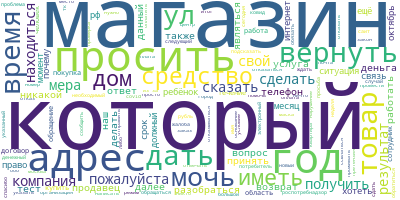

In [10]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

**Векторизация (TF-IDF)**

In [11]:
# Соединим нормализованные слова обратно в тексты
for i in range(1500):
    norm_data[i] = ' '.join(norm_data[i])

In [12]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(norm_data)

In [13]:
# Запишем в словарь
count_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
count_dict

{'aa': 7.620739651073516,
 'aaa': 7.620739651073516,
 'abdcbbcbee': 7.620739651073516,
 'abgrigorieva': 7.620739651073516,
 'about': 6.522127362405407,
 'ac': 7.620739651073516,
 'acer': 7.620739651073516,
 'adidas': 7.620739651073516,
 'ads': 7.620739651073516,
 'adsmanager': 7.620739651073516,
 'adz': 7.620739651073516,
 'affex': 7.620739651073516,
 'airlines': 7.215274542965353,
 'airpods': 7.620739651073516,
 'airpodspro': 7.620739651073516,
 'airpord': 7.620739651073516,
 'akhann': 7.620739651073516,
 'alekseyp': 7.620739651073516,
 'aliexpress': 6.927592470513571,
 'aliexpressru': 7.620739651073516,
 'alinochka': 7.620739651073516,
 'alle': 7.620739651073516,
 'aller': 7.620739651073516,
 'altaimagru': 7.620739651073516,
 'alyuminievyy': 7.620739651073516,
 'am': 7.620739651073516,
 'amd': 7.620739651073516,
 'amp': 7.620739651073516,
 'analyse': 7.620739651073516,
 'annaaleshenkina': 7.620739651073516,
 'annamatveeva': 7.620739651073516,
 'apparat': 7.620739651073516,
 'appeals'

**Тематическое моделирование (LSI)**

In [14]:
# term-document matrix

# np.linalg.svd не принимает sparse matrix после tfidf, поэтому переводим в обычную матрицу
X = X.todense() 

In [15]:
X.shape

(1500, 12247)

1500 строк - документов (жалоб)  
12249 столбоцов - слов, встречающихся в этих документах

Согласно теории, должно быть наоборот, в term-document matrix столбцы должны быть документами, а строчки терминами. Транспонируем.

In [16]:
X = X.T
X.shape

(12247, 1500)

In [17]:
# Получаем сингулярное разложение нашей матрицы

svd = np.linalg.svd(X, full_matrices = False)

In [18]:
print(svd[0].shape)
print(svd[1].shape)
print(svd[2].shape)

(12247, 1500)
(1500,)
(1500, 1500)


In [19]:
u = svd[0] # term * topic
s = svd[1] # Topic Importance
vT = svd[2] # topic * doc

In [20]:
# Topic Importance
s[:20]

array([5.76971719, 3.49090477, 3.23308917, 3.10095708, 2.66015166,
       2.45739849, 2.39812634, 2.28646575, 2.19985325, 2.14170277,
       2.12489689, 2.09450266, 2.06838776, 2.03834361, 2.00538095,
       1.96816285, 1.94648794, 1.9255239 , 1.91557925, 1.89260828])

Думаю, можно взять первые пять топиков. Также, удобнее брать строчки, а не столбцы (топики), поэтому транспонируем матрицу U.

In [21]:
uT = u.T
topics = np.array(uT[:5])

Для более понятного вывода создадим словарь, где будут видны слова и их значимость для топиков. Еще я подумала, что стоит оставить только самые значимые слова в этих топиках (по 20 слов).

In [22]:
def topic(dic, topics, num):
    topic_dic = dict()
    # Скопируем словарь, который получили после векторизации (count_dict)
    # Затем заменим значения на значимость этих слов для топиков
    for i,key in enumerate(dic):
        topic_dic[key] = topics[num][i]
    
    # Затем сортируем словарь по значениям (важности слов для топика) в убывающем порядке   
    list_dic = list(topic_dic.items())
    list_dic.sort(key=lambda i: i[1], reverse=True)
    
    # И возьмем только первые 20 слов
    list_dic = list_dic[:20]
    return list_dic

topic_1 = topic(count_dict, topics, 0)
topic_2 = topic(count_dict, topics, 1)
topic_3 = topic(count_dict, topics, 2)
topic_4 = topic(count_dict, topics, 3)
topic_5 = topic(count_dict, topics, 4)

Наконец, можем посмотреть на наши топики.

In [23]:
# Например
topic_2

[('магазин', 0.20299037742164489),
 ('товар', 0.1401372856826386),
 ('возврат', 0.0992959726572399),
 ('вернуть', 0.08900972850902032),
 ('сигарета', 0.08285563554089279),
 ('продавать', 0.08135365476422857),
 ('продавец', 0.08129790193700931),
 ('интернет', 0.0781207448871929),
 ('продажа', 0.07742105102777357),
 ('деньга', 0.07485011665686822),
 ('средство', 0.0744506610563264),
 ('челны', 0.06742404541543914),
 ('адрес', 0.06723290459942348),
 ('набережная', 0.06393641993669678),
 ('денежный', 0.06318235218484773),
 ('ул', 0.062436953517084434),
 ('приобрести', 0.0595931664704334),
 ('закон', 0.059333567968863715),
 ('покупка', 0.05881237188540209),
 ('право', 0.057836800992191115)]